### Facial Landmark/Keypoint Detection

The dataset here is based on the Kaggle facial keypoint detection challenge:
https://www.kaggle.com/c/facial-keypoints-detection




Let us import the dataset and visualize the facial keypoints 
The pickle files here were created by process.py run on the original Kaggle dataset. 

In [3]:
import pickle
import time
from sklearn.metrics import roc_auc_score,roc_curve,auc
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense,Dropout,Conv2D,Activation,MaxPool2D,BatchNormalization,Flatten,Conv2DTranspose,Reshape,Input
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam,SGD,RMSprop
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split


IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96

#Import dataset
with open('X.pickle','rb') as xfp:
    X = pickle.load(xfp)

with open('y.pickle','rb') as yfp:
    y = pickle.load(yfp)    

   
def show_image(X, Y):
    
    #Show image
    plt.imshow(X[:,:,0],cmap='gray')
    plt.show()
    
    #copy image - we dont want to alter the original
    img = np.copy(X)
    
    #Iterate through keypts and skip by 2  since they are stored in x,y pairs
    for i in range(0,Y.shape[0],2):
        #If y coord is part of image and x coord is part of image - change pixel color
        if 0 < Y[i+1] < IMAGE_HEIGHT and 0 < Y[i] < IMAGE_WIDTH:
            img[int(Y[i+1]),int(Y[i]),0] = 255
    
    #Show image with keypoints
    plt.imshow(img[:,:,0],cmap='gray')
        


### Understanding the data

The images have upto 15 landmarks (x,y) pairs corresponding to the yellow dots in the second image below. 

The 15 landmarks are:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

So the task is to predict the 30 coordinates corresponding to the 15 landmarks. 

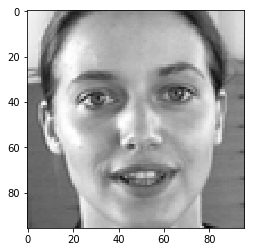

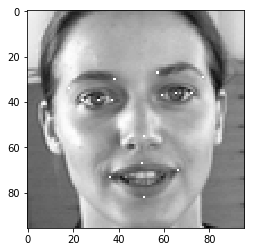

In [13]:
show_image(X[20],y[20])

### Model Definition

We will use a Resnet50 model (https://arxiv.org/abs/1512.03385) as a baseline model for transfer learning with the fully connected layer removed. A custom deep fully connected network will be added on top of the ResNet50 model and stored as the final model. 


In [15]:
def createResnetModel ():
    
    #baseline Resnet50 model
    base_model = ResNet50(include_top=False, input_tensor=Input(shape=(96,96,3)), pooling='avg')
    #Freeze all layers - we dont want to learn the weights here
    base_model.trainable = False
    
    
    #Top model added after Resnet
    
    #Model params
    
    #Define dropout value
    dropout  = 0.5
    #Kernel and Bias initializer
    kernel_init  = 'he_uniform'
    #Enable or disable Batch Normalization
    use_bn = False
    
    #Dense layer
    top_model = Sequential()
    top_model.add(Dense(512,  input_shape=(2048,),kernel_initializer=kernel_init))
    if use_bn:
        top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    
    #Dense layer    
    top_model.add(Dense(256, kernel_initializer=kernel_init))
    if use_bn:
        top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))

    #Dropout    
    top_model.add(Dropout(dropout))
    
    #Dense layer
    top_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01),kernel_initializer=kernel_init))
    if use_bn:
        top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    
    #Dropout    
    top_model.add(Dropout(dropout))
    
    #Dense layer
    top_model.add(Dense(96, kernel_regularizer=regularizers.l2(0.01),kernel_initializer=kernel_init))
    if use_bn:
        top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    
    #Dropout    
    top_model.add(Dropout(dropout))
    
    top_model.add(Dense(48, kernel_regularizer=regularizers.l2(0.01),kernel_initializer=kernel_init))
    if use_bn:
        top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    
    
    top_model.add(Dense(30))
    
    top_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
    
    #Combine models
    final_model = Sequential([base_model, top_model])
    final_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
    final_model.summary()

    return final_model


In [16]:
def trainModel (datagen, model, X, y):
       
        print ("Training model \n")
        
        
        X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2, shuffle=True)
      

        #Use early stopping to avoid overfit
        earlystop = EarlyStopping(patience=early_stop_epochs,monitor='val_loss')
        reduce_lr =  ReduceLROnPlateau(monitor='loss', factor=0.1, \
                                       verbose=verbose,  mode='min')
        
        callbacks_list = [earlystop,reduce_lr]
        
        #track model training time
        start_time = time.time()

        generator = datagen.flow(X_train, y_train, batch_size = batch_size)

        # Fitting the model to the training set
        model_info =  model.fit_generator(
                generator,
                steps_per_epoch=batch_size,
                epochs=epochs,
                shuffle=True,
                verbose=verbose,
                validation_data = (X_val, y_val),
                callbacks = callbacks_list)
            
        # plot model history
        plot_model_history(model_info,'mean_absolute_error','val_mean_absolute_error')
   
        #Evaluate the model
        scores = model.evaluate(X_val,y_val)
        print("\n%s: %.2f\n" % (model.metrics_names[1],scores[1]))
 
         

        end_time = time.time()
        train_time = (end_time - start_time)/60
  
        print("Model train time = %f minutes" % train_time)
        
        
def trainModelKfold (datagen, model, X, y):
       
        print ("Training model using K-Fold cross val\n")
        
     
        
        #K-Fold Cross validation
        kf = KFold(n_splits=5,shuffle=True, random_state=1) 

        #Store cross val scores
        cv_scores = []

        #Use early stopping to avoid overfit
        earlystop = EarlyStopping(patience=early_stop_epochs,monitor='val_loss')
        reduce_lr =  ReduceLROnPlateau(monitor='loss', factor=0.1, \
                                       verbose=verbose,  mode='min')
        
        callbacks_list = [earlystop,reduce_lr]
        
        #track model training time
        start_time = time.time()

        #Do k-fold cross val across dataset and store scores
        for train_index, val_index in kf.split(X):
            
            
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            generator = datagen.flow(X_train, y_train, batch_size = batch_size)

            # Fitting the model to the training set
            model_info =  model.fit_generator(
                generator,
                steps_per_epoch=batch_size,
                epochs=epochs,
                shuffle=True,
                verbose=verbose,
                validation_data = (X_val, y_val),
                callbacks = callbacks_list)
            
            # plot model history
            plot_model_history(model_info,'mean_absolute_error','val_mean_absolute_error')
   
            #Evaluate the model
            scores = model.evaluate(X_val,y_val)
            print("\n%s: %.2f%%\n" % (model.metrics_names[1],scores[1]*100))
            cv_scores.append(scores[1]*100)
 
         

        end_time = time.time()
        train_time = (end_time - start_time)/60
  
        print("Model train time = %f minutes" % train_time)
        print("Overall Accuracy = %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))

    


def plot_model_history(model_history,train_metric,val_metric):
        
        fig, axs = plt.subplots(1,2,figsize=(15,5))
        
        # summarize history for accuracy
        axs[0].plot(range(1,len(model_history.history[train_metric])+1),model_history.history[train_metric])
        axs[0].plot(range(1,len(model_history.history[val_metric])+1),model_history.history[val_metric])
        axs[0].set_title(train_metric)
        axs[0].set_ylabel(train_metric)
        axs[0].set_xlabel('Epoch')
        axs[0].set_xticks(np.arange(1,len(model_history.history[train_metric])+1),len(model_history.history[train_metric])/10)
        axs[0].legend(['train', 'val'], loc='best')
        
        # summarize history for loss
        axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
        axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
        axs[1].set_title('Model Loss')
        axs[1].set_ylabel('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
        axs[1].legend(['train', 'val'], loc='best')
        plt.show()





### Data Augmentation

The Keras ImageDataGenerator class will be used to augment the images. Below is the starting point, where we use width and height pixel shifts along with pixel value rescaling between 0-1. 

In [20]:
#Data augmentation    
train_datagen = ImageDataGenerator(
        #rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #fill_mode='nearest'
        )

#Model hyper params
epochs  = 100
batch_size = 32
early_stop_epochs = 25
verbose = True

#Baseline images are 1 channel. Convert to 3 channel 
x = np.array([ X[:,:,:,0],X[:,:,:,0],X[:,:,:,0]])

#Move axes to match (batches,width,height,channels)
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,1,2)
x = np.swapaxes(x,2,3)





In [18]:
#Create Resnet based model
model = createResnetModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 30)                1231822   
Total params: 24,819,534
Trainable params: 1,231,822
Non-trainable params: 23,587,712
_________________________________________________________________


Training model 

Epoch 1/100
32/32 [==============================] - 367s 11s/step - loss: 301.5679 - mean_absolute_error: 13.3992 - val_loss: 296.0088 - val_mean_absolute_error: 14.0722
Epoch 2/100
32/32 [==============================] - 339s 11s/step - loss: 274.3680 - mean_absolute_error: 12.7822 - val_loss: 621.2570 - val_mean_absolute_error: 21.8708
Epoch 3/100
32/32 [==============================] - 364s 11s/step - loss: 254.9951 - mean_absolute_error: 12.2411 - val_loss: 208.1640 - val_mean_absolute_error: 12.0108
Epoch 4/100
32/32 [==============================] - 360s 11s/step - loss: 241.3226 - mean_absolute_error: 11.9320 - val_loss: 208.6056 - val_mean_absolute_error: 11.5144
Epoch 5/100
32/32 [==============================] - 350s 11s/step - loss: 256.3174 - mean_absolute_error: 12.2089 - val_loss: 53.9005 - val_mean_absolute_error: 5.2616
Epoch 6/100
32/32 [==============================] - 359s 11s/step - loss: 240.0072 - mean_absolute_error: 11.7024 - val_loss: 250

32/32 [==============================] - 334s 10s/step - loss: 55.2654 - mean_absolute_error: 5.4354 - val_loss: 21.6833 - val_mean_absolute_error: 3.2681
Epoch 50/100
32/32 [==============================] - 341s 11s/step - loss: 52.9299 - mean_absolute_error: 5.3029 - val_loss: 23.2499 - val_mean_absolute_error: 3.4822
Epoch 51/100
32/32 [==============================] - 357s 11s/step - loss: 54.5124 - mean_absolute_error: 5.3927 - val_loss: 20.6891 - val_mean_absolute_error: 3.1858
Epoch 52/100
32/32 [==============================] - 348s 11s/step - loss: 53.2485 - mean_absolute_error: 5.2755 - val_loss: 29.7944 - val_mean_absolute_error: 4.1666
Epoch 53/100
32/32 [==============================] - 346s 11s/step - loss: 52.6768 - mean_absolute_error: 5.2945 - val_loss: 18.6946 - val_mean_absolute_error: 2.9281
Epoch 54/100
32/32 [==============================] - 363s 11s/step - loss: 50.8810 - mean_absolute_error: 5.1499 - val_loss: 25.4395 - val_mean_absolute_error: 3.7337
Epoch

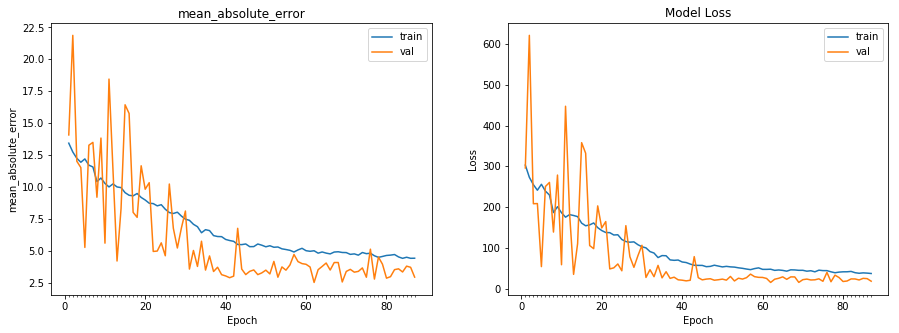

428/428 [==============================] - 146s 341ms/step

mean_absolute_error: 2.94

Model train time = 696.820148 minutes


In [21]:
#Train model 
trainModel(train_datagen,model,x,y)

In [22]:
#Save model                   
model.save('resnet_transfer.h5')

### Visualizing predictions

Let us define a function to show the true keypoints alongside the predicted ones. 

In [23]:
def show_predictions(X, Y,Y_true):
    
   
    
    #copy image - we dont want to alter the original
    img = np.copy(X)
    
    ###Predicted labels
    
    #Iterate through keypts and skip by 2  since they are stored in x,y pairs
    for i in range(0,Y.shape[0],2):
        #If y coord is part of image and x coord is part of image - change pixel color
        if 0 < Y[i+1] < IMAGE_HEIGHT and 0 < Y[i] < IMAGE_WIDTH:
            img[int(Y[i+1]),int(Y[i]),0] = 255
    
    ###Ground truth
    #Iterate through keypts and skip by 2  since they are stored in x,y pairs
    for i in range(0,Y_true.shape[0],2):
        #If y coord is part of image and x coord is part of image - change pixel color
        if 0 < Y_true[i+1] < IMAGE_HEIGHT and 0 < Y_true[i] < IMAGE_WIDTH:
            img[int(Y_true[i+1]),int(Y_true[i]),0] = 3
            
    #Show image with keypoints
    plt.imshow(img[:,:,0],cmap='gray')

    
  




In [24]:
with open('X_test.pickle','rb') as f:
    X_test = pickle.load(f)
    
#Baseline images are 1 channel. Convert to 3 channel 
x_test = np.array([ X_test[:,:,:,0],X_test[:,:,:,0],X_test[:,:,:,0]])

#Move axes to match (batches,width,height,channels)
x_test = np.swapaxes(x_test,0,1)
x_test = np.swapaxes(x_test,1,2)
x_test = np.swapaxes(x_test,2,3)


with open('X.pickle','rb') as f:
    X = pickle.load(f)
   
with open('y.pickle','rb') as f:
    y = pickle.load(f)
    
#Baseline images are 1 channel. Convert to 3 channel 
x = np.array([ X[:,:,:,0],X[:,:,:,0],X[:,:,:,0]])

#Move axes to match (batches,width,height,channels)
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,1,2)
x = np.swapaxes(x,2,3)


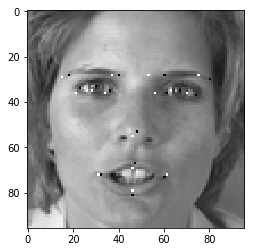

In [31]:
#Select image index here
img_indx = 33

#Get prediction and dsiaply results
y_pred = model.predict(x[img_indx:(img_indx+1)])
y_true = y[img_indx:(img_indx+1)]

show_predictions(x[img_indx], y_pred[0],y_true[0])

You can see that the yellow (predicted) and black (actual) keypoints align pretty closely. We could optimize the model hyperparams and experiment with more data augmentation to achieve better results here.